Epoch 1: Loss = 0.840110
Epoch 2: Loss = 0.019880
Epoch 3: Loss = 0.014825
Epoch 4: Loss = 0.011370
Epoch 5: Loss = 0.008841
Epoch 6: Loss = 0.006929
Epoch 7: Loss = 0.005552
Epoch 8: Loss = 0.004517
Epoch 9: Loss = 0.003651
Epoch 10: Loss = 0.003101
Epoch 11: Loss = 0.002605
Epoch 12: Loss = 0.002304
Epoch 13: Loss = 0.001973
Epoch 14: Loss = 0.001758
Epoch 15: Loss = 0.002094
Epoch 16: Loss = 0.002967
Epoch 17: Loss = 0.002587
Epoch 18: Loss = 0.002523
Epoch 19: Loss = 0.002839
Epoch 20: Loss = 0.001939
Epoch 21: Loss = 0.001888
Epoch 22: Loss = 0.002370
Epoch 23: Loss = 0.002385
Epoch 24: Loss = 0.001270
Epoch 25: Loss = 0.002154
Epoch 26: Loss = 0.001345
Epoch 27: Loss = 0.001961
Epoch 28: Loss = 0.001273
Epoch 29: Loss = 0.001201
Epoch 30: Loss = 0.001452
Epoch 31: Loss = 0.001207
Epoch 32: Loss = 0.001215
Epoch 33: Loss = 0.001285
Epoch 34: Loss = 0.000829
Epoch 35: Loss = 0.001064
Epoch 36: Loss = 0.000940
Epoch 37: Loss = 0.000842
Epoch 38: Loss = 0.001015
Epoch 39: Loss = 0.00

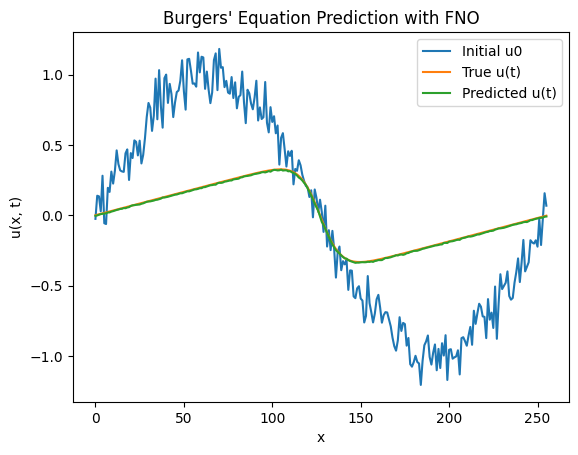

In [24]:
# Burgers' Equation with Fourier Neural Operator (FNO)

import numpy as np
import torch
import torch.nn as nn
import torch.fft
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ===========================
# Step 1: Stable Burgers Solver
# ===========================
def burgers_solver(u0, T=1.0, N=256, nu=0.01, dt=0.0001):
    dx = 1 / N
    x = np.linspace(0, 1, N, endpoint=False)
    u = u0.copy()
    num_steps = int(T / dt)
    for _ in range(num_steps):
        u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
        u_x = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)
        u = u + dt * (nu * u_xx - u * u_x)
    return u

# ===========================
# Step 2: Dataset
# ===========================
class BurgersDataset(Dataset):
    def __init__(self, n_samples=1000, N=256):
        self.N = N
        self.u0_list = []
        self.ut_list = []
        for _ in range(n_samples):
            x = np.linspace(0, 1, N)
            u0 = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(N)
            ut = burgers_solver(u0, N=N)
            self.u0_list.append(torch.tensor(u0, dtype=torch.float32))
            self.ut_list.append(torch.tensor(ut, dtype=torch.float32))

    def __len__(self):
        return len(self.u0_list)

    def __getitem__(self, idx):
        return self.u0_list[idx], self.ut_list[idx]

# ===========================
# Step 3: FNO Model
# ===========================
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        # Use a reasonably large number for modes, e.g., 64, to avoid mismatch
        self.weights = nn.Parameter(torch.randn(out_channels, in_channels, modes, dtype=torch.cfloat))

    def forward(self, x):
        B, C, N = x.shape  # [B, in_channels, N]
        x_ft = torch.fft.rfft(x, dim=2)  # [B, in_channels, N//2 + 1]
        S = x_ft.shape[-1]
        modes = min(self.modes, S)
        x_ft_trunc = x_ft[:, :, :modes]  # [B, C_in, modes]
        weights_trunc = self.weights[:, :, :modes]  # [C_out, C_in, modes]
        out_ft_trunc = torch.einsum("bci,oci->bco", x_ft_trunc, weights_trunc)  # [B, C_out, modes]

        out_ft = torch.zeros(B, self.out_channels, S, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :modes] = out_ft_trunc

        x = torch.fft.irfft(out_ft, n=N, dim=2)  # [B, C_out, N]
        return x

class SimpleFNO1d(nn.Module):
    def __init__(self, modes=64, width=64):  # Set modes=64 or higher, but <= N//2+1
        super().__init__()
        self.fc0 = nn.Linear(1, width)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.conv2 = SpectralConv1d(width, width, modes)
        self.fc1 = nn.Linear(width, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)               # [B, N, 1]
        x = self.fc0(x)                   # [B, N, width]
        x = x.permute(0, 2, 1)            # [B, width, N]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)            # [B, N, width]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)       # [B, N]
        return x

# ===========================
# Step 4: Training
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleFNO1d().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

dataset = BurgersDataset(n_samples=2000)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for epoch in range(100):
    model.train()
    total_loss = 0
    for u0, ut in loader:
        u0, ut = u0.to(device), ut.to(device)
        optimizer.zero_grad()
        pred = model(u0)
        loss = loss_fn(pred, ut)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.6f}")

# ===========================
# Step 5: Visualization
# ===========================
model.eval()
u0, ut = dataset[0]
with torch.no_grad():
    pred = model(u0.unsqueeze(0).to(device)).cpu().squeeze()

plt.plot(u0.numpy(), label="Initial u0")
plt.plot(ut.numpy(), label="True u(t)")
plt.plot(pred.numpy(), label="Predicted u(t)")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.title("Burgers' Equation Prediction with FNO")
plt.show()
